In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.arima_model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

**Part 1**

In [2]:
def show_stock_features(stock_name, start, end, freq='D'):
    # read the related CSV file
    stock = pd.read_csv('./files/' + stock_name + '.us.txt', delimiter=',')
    
    # drop the columns with all zero values
    stock = stock.loc[:, (stock != 0).any()]
    
    # set index with Date column
    stock.set_index('Date', inplace=True)
    
    # convert index to datetime
    stock.index = pd.to_datetime(stock.index)
    
    # fill the missing value (interpolation)
    stock.ffill(inplace=True)
    
    # get needed columns
    stock = stock.loc[:, ['Open', 'High', 'Low', 'Close']]
    
    # check the frequency
    if freq == 'M':
        # monthly #
        # get the last date of the end month
        time_period = pd.date_range(start, end, freq='M')
        end = time_period[-1] + 1
        
        # get data over the given period
        data = pd.DataFrame(stock, index=pd.date_range(start, end))
        
        # get the average of values for a month and plot them
        ax = data.resample('M').mean().plot(figsize=(18, 8), style=['-', '--', ':', '-'])
        ax.set(xlabel='Month', ylabel='Stock Prices')
    else:
        # daily as default #
        # get data over the given period
        data = pd.DataFrame(stock, index=pd.date_range(start, end))

        # plot data
        ax = data.plot(figsize=(18, 8), style=['-', '--', ':', '-'])
        ax.set(xlabel='Day', ylabel='Stock Prices')

Where the stock name is ‘ahpi’ and time period is from 2008-01 to 2011-12.

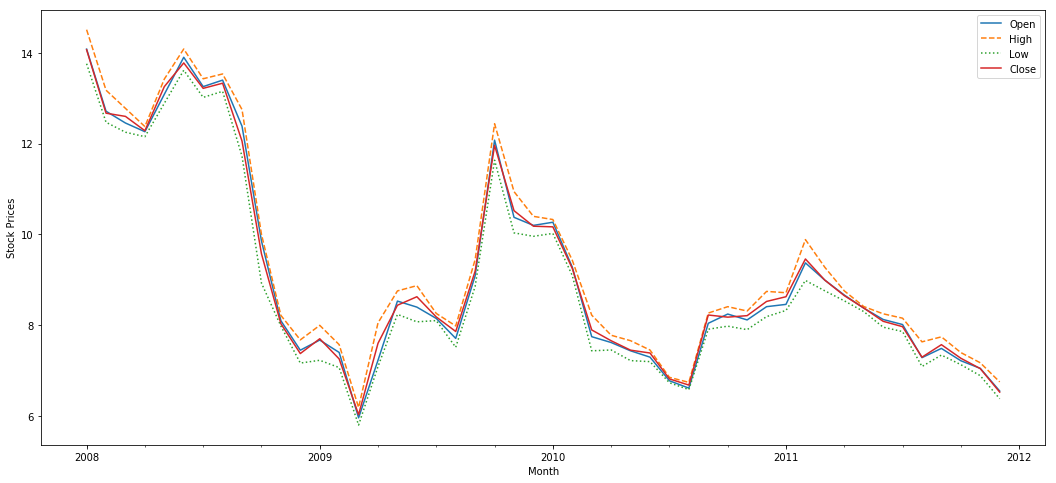

In [3]:
show_stock_features('ahpi', start='2008-01', end='2011-12', freq='M')

Where stock name is ‘aker’ and the period is between 2014-01-24 and 2017- 10-24

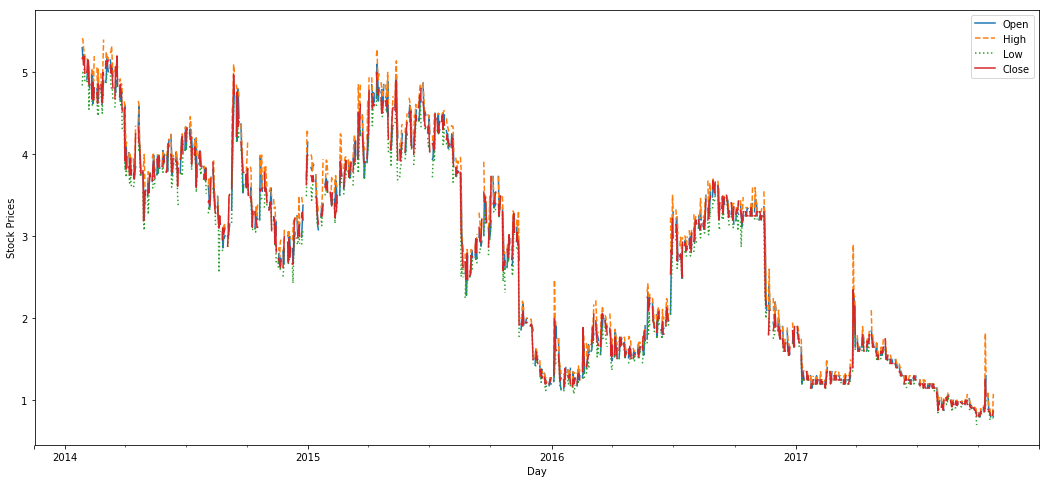

In [4]:
show_stock_features('aker', start='2014-01-24', end='2017-10-24')

**Part 2**

In [7]:
def show_multiple_stocks(stock_names, start, end):
    data = pd.DataFrame()
    for name in stock_names:
        # read the related CSV file
        stock = pd.read_csv('./files/' + name + '.us.txt', delimiter=',')
        
        # get 'Close' prices only
        stock = stock.loc[:, ['Date', 'Close']]
        
        # change the column name
        stock.columns = ['Date', name]
        
        # merge 'Close' prices from multiple stocks
        if data.shape[0] == 0:
            data = stock # first stock values
        else:
            data = data.merge(stock, on='Date', how='outer')
    
    # set index with Date column
    data.set_index('Date', inplace=True)   
        
    # convert index to datetime
    data.index = pd.to_datetime(data.index)
        
    # get data over the given period
    data = pd.DataFrame(data, index=pd.date_range(start, end))
    
    # fill the missing value (interpolation)
    data.ffill(inplace=True)
    
    # normalize data using the base value of each stock from the start date
    data_norm = data/data.loc[start]
    
    # plot normalized data
    fig = plt.figure(figsize=(18, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(data_norm)
    ax.legend(stock_names) # add legend
    
    # set label for the axes
    ax.set(xlabel='Months', ylabel='Normalized Close Prices')
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%Y'))
    
    # find the stock symbols has the highest 'Close' price in October
    start_date = datetime.strptime(start, '%Y.%m.%d')
    data_oct = data_norm.loc['{}-10'.format(start_date.year)]
    max_oct_stock = data_oct.max().idxmax() # find stock that has the highest 'Close' price value
    max_oct_idx = data_oct[max_oct_stock].idxmax() # index of the highest 'Close' price value

    # add annotation
    ax.annotate("Highest in October", xy=(mdates.date2num(max_oct_idx), data_oct.max().max()), 
                xytext=(10, 10), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
    
    # find the stock symbols has the lowest ‘Close’ price in February
    data_feb = data_norm.loc['{}-02'.format(start_date.year)]
    min_feb_stock = data_feb.min().idxmin() # find stock that has the lowest 'Close' price value
    min_feb_idx = data_feb[min_feb_stock].idxmin() # index of the lowest 'Close' price value
    
    # add annotation
    ax.annotate("Lowest in February", xy=(mdates.date2num(min_feb_idx), data_feb.min().min()), 
                xytext=(20, -10), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))

    return data_norm

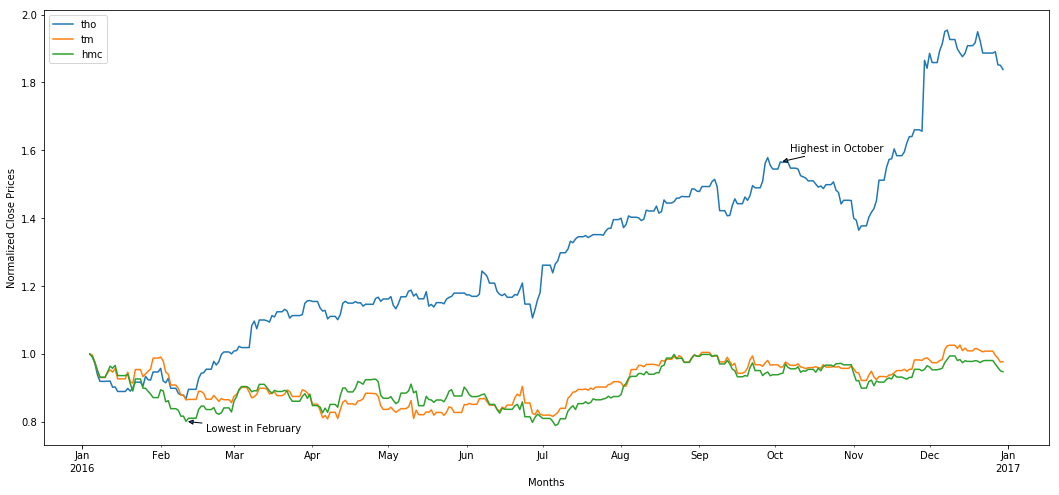

In [8]:
result = show_multiple_stocks(['tho', 'tm', 'hmc'], start='2016.01.04', end='2016.12.30')

In [9]:
result.head(10)

,tho,tm,hmc
2016-01-04,1.000000,1.000000,1.000000
2016-01-05,0.991507,0.997288,0.992268
2016-01-06,0.972166,0.974659,0.975785
2016-01-07,0.939325,0.951521,0.951898
2016-01-08,0.919780,0.930842,0.932256
2016-01-09,0.919780,0.930842,0.932256
2016-01-10,0.919780,0.930842,0.932256
2016-01-11,0.920151,0.945250,0.947391
2016-01-12,0.920689,0.953640,0.964532
2016-01-13,0.902591,0.946690,0.958380


**Part 3:**  
**3.1 ARIMA**

In [10]:
# read the dataset 'aapl'
aapl = pd.read_csv('./files/aapl.us.txt', delimiter=',')

# set index with Date column
aapl.set_index('Date', inplace=True)    
        
# convert index to datetime
aapl.index = pd.to_datetime(aapl.index)
        
# select a subset of data containing information from 2014 to 2016 (including 2016)
aapl = pd.DataFrame(aapl, index=pd.date_range('2014', '2017', closed='left'))
    
# fill the missing value (interpolation)
aapl.ffill(inplace=True)
aapl.bfill(inplace=True)

# get new data frame with 'Open' prices
aapl_open = aapl.loc[:, 'Open']

# Divide the dataset into two sets:
trainset = aapl_open[:'2015']
testset = aapl_open['2016']

# Store all predictions in a list
predictions = list()

# for each sample in testset
for index, x in testset.items():
    # Define the model
    model = ARIMA(trainset, order=(3, 1, 0))
    # create an ARIMA model on the training data
    fitted_model = model.fit(disp=0)
    # get the predicted value for the given test sample
    forecast = fitted_model.forecast()
    # store its first returned argument as the predicted value
    predictions.append(forecast[0])
    # append test sample to trainset to predict for next day
    trainset[index] = x
    
# evaluate the prediction performance using square root of ‘mean_squared_error’ metric
rmse = np.sqrt(mean_squared_error(testset, predictions))
print('Prediction Performance: RMSE = {:.3f}'.format(rmse))

Prediction Performance: RMSE = 1.292


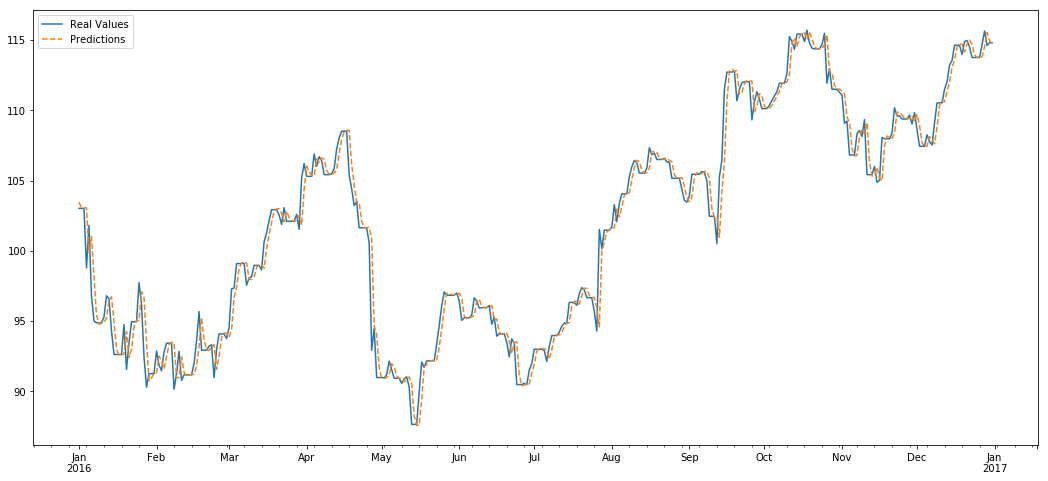

In [11]:
# Plot the predictions against the real values in testset
# convert predictions to data frame
predictions = pd.DataFrame(predictions, index = testset.index, columns=['Predictions'])
# concat testset and predictions into one dataframe
plot_data = pd.concat([testset, predictions], axis=1)
plot_data.columns = ['Real Values', 'Predictions']
# plot
plot_data.plot(figsize=(18, 8), style=['-', '--'])

**3.2 Random Forest**

In [12]:
# read the dataset 'aapl'
aapl = pd.read_csv('./files/aapl.us.txt', delimiter=',')

# drop the columns with all zero values
aapl = aapl.loc[:, (aapl != 0).any()]

# set index with Date column
aapl.set_index('Date', inplace=True)    
        
# convert index to datetime
aapl.index = pd.to_datetime(aapl.index)
        
# select a subset of data containing information from 2012 to 2016 (including 2016)
# we also get data from date 2017-01-01 for later data shifting
aapl_subset = pd.DataFrame(aapl, index=pd.date_range('2012', '2017'))
    
# fill the missing value (interpolation)
aapl_subset.ffill(inplace=True)
aapl_subset.bfill(inplace=True)

# get data of next day Open by shifting value of 'Open' price of current day by one backward
aapl_open_next_day = aapl_subset.loc[:, 'Open']
aapl_open_next_day = aapl_open_next_day.shift(-1)
aapl_open_next_day.rename('Next Day Open', inplace=True)

# add new column for the 'Open' price of next day
aapl_subset = pd.concat([aapl_subset, aapl_open_next_day], axis=1)

# remove the last row (2017-01-01)
aapl_subset = aapl_subset[:-1]

# create trainset and testset
trainset = aapl_subset[:'2015']
testset = aapl_subset['2016']
train_X = trainset.values[:, :5]
train_Y = trainset.values[:, 5]
test_X = testset.values[:, :5]
test_Y = testset.values[:, 5]

# Build a random forest regressor model using default parameters
model = RandomForestRegressor()

# train the model on trainset values
model.fit(train_X, train_Y)

# Create predictions by calling 'predict' function of the fitted model
predictions = model.predict(test_X)

# Use RMSE metric error to compute the prediction error rate
rmse = np.sqrt(mean_squared_error(test_Y, predictions))
print('Prediction Performance: RMSE = {:.3f}'.format(rmse))

Prediction Performance: RMSE = 1.109


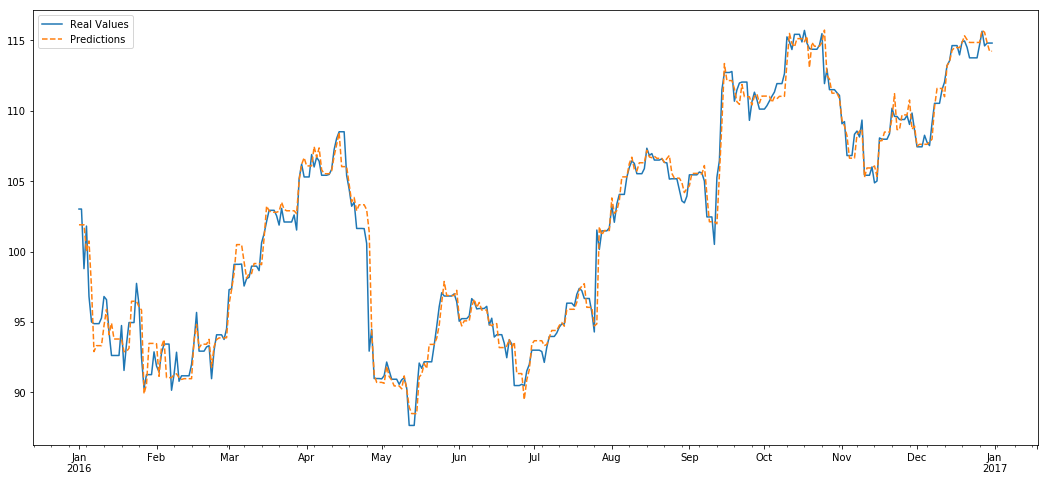

In [139]:
# Plot the predictions against the real values in testset
# convert predictions and test_Y to data frame
predictions = pd.DataFrame(predictions, index = testset.index, columns=['Predictions'])
test_Y = pd.DataFrame(test_Y, index = testset.index, columns=['Real Values'])

# concat test_Y and predictions into one dataframe
plot_data = pd.concat([test_Y, predictions], axis=1)

# plot
plot_data.plot(figsize=(18, 8), style=['-', '--'])